# Lab 7: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"L7_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before 23:59 on December 5, 2018 and put **"AML-L7"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Non-negative Matrix Factorization is a model where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.

Fill in the following class that implements a NMF by multiplicative updates using the Frobenius norm or the Kullback-Leiber divergence as loss function (implement both), you can add more methods if needed. Try 10 different random initializations and choose the best one.

In [2]:
import pdb
from scipy import sparse


In [3]:
class my_NMF():
    
    def __init__(self, n_components, loss, epsilon, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_: float
            convergence
        loss_ = {"Frobenius", "KL"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.loss_ = loss
        self.epsilon_ = epsilon
        self.W_ = None
        self.H_ = None
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """  
        np.random.seed(123)
        X = X.T
        p, n = X.shape
        r = self.n_components_
        self.W_ = np.random.rand(p, r)
        self.H_ = np.random.rand(r, n)
        
        it = 0
        converge = False
        errs = []
        while not converge : 
            H = self.H_
            W = self.W_
            
            if self.loss_ == 'Frobenius' :
                W = W * np.dot(X, H.T)/np.dot(W, np.dot(H, H.T))
                H = H * np.dot(W.T, X)/np.dot(W.T, np.dot(W, H))
                W = np.clip(W, 10e-18, 10e8)
                H = np.clip(H, 10e-18, 10e8)                
            elif self.loss_ == 'KL' :
                #pdb.set_trace()  
                W = W * (X/(W.dot(H))).dot(H.T)/np.sum(H, axis = 1) 
                H = H *(W.T).dot(X/(W.dot(H)))/(np.sum(W, axis = 0)[:, np.newaxis])
                W = np.clip(W, 10e-18, 10e8)
                H = np.clip(H, 10e-18, 10e8)         
            err = np.max(np.abs(W.dot(H) - self.W_.dot(self.H_)))
            errs.append(err)
            it += 1
            if it > self.max_iter_ or err < self.epsilon_ :
                converge = True
            self.H_ = H
            self.W_ = W
            if it%50 == 0 :
                print(f" iteration {it} error = {err}") 
        plt.plot(errs[1:])
        plt.title('Norme infinie (WH_1 - WH_0)')
        return self

**Bonus (not graded)**: Implement the regularized version

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

(400, 4096)

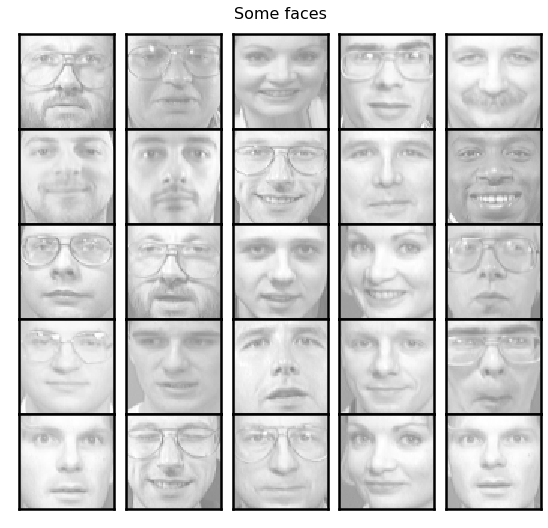

In [4]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(1.5 * n_col, 1.5 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

faces.shape

Apply your NMF algorithm for this dataset and plot the approximated face pictures.

### Note :
It is important to update the weights successively otherwise the algorithm will never converge !
More precisely, one must first update W(or H) and use the new value of W (or H) to update H (or W).


 iteration 50 error = 0.02047509305757733
 iteration 100 error = 0.0064092838964214804
 iteration 150 error = 0.003429374656104156
 iteration 200 error = 0.0024959574507008586
 iteration 250 error = 0.0023913375638743295
 iteration 300 error = 0.001156207340398896
 iteration 350 error = 0.0008278300101135505
 iteration 400 error = 0.0007466968833426124
 iteration 450 error = 0.0005336148261181339
 iteration 500 error = 0.0004283220993744896
 iteration 550 error = 0.0003860433306184241
 iteration 600 error = 0.0003580253695008029
 iteration 650 error = 0.00026769024344719394
 iteration 700 error = 0.0002608776054173756
 iteration 750 error = 0.00031474335351333593
 iteration 800 error = 0.000290547332480795
 iteration 850 error = 0.0002849208471701892
 iteration 900 error = 0.00022314716284788094
 iteration 950 error = 0.00021347568979823706
 iteration 1000 error = 0.0002220294444371662


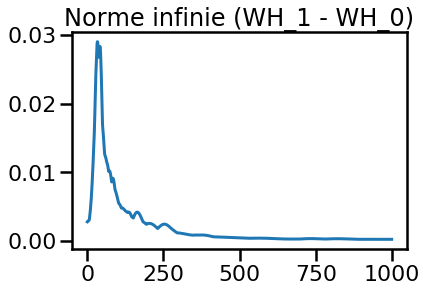

In [5]:
n_components=64
model = my_NMF(n_components, loss = 'KL', epsilon = 1e-4, max_iter = 1000)
model.fit_transform(faces);

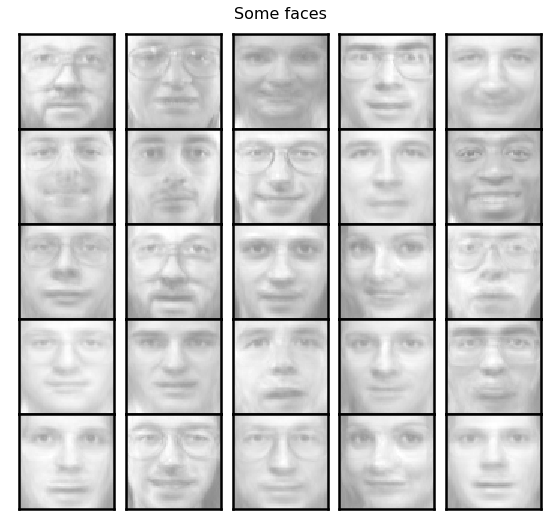

In [6]:
approx_faces = model.W_.dot(model.H_).T
plot_faces("Some faces", approx_faces[:25], image_shape)

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Choose one face, plot its corresponding weights (in $H$) in a grid  and explain the interpretation of both factor matrices.

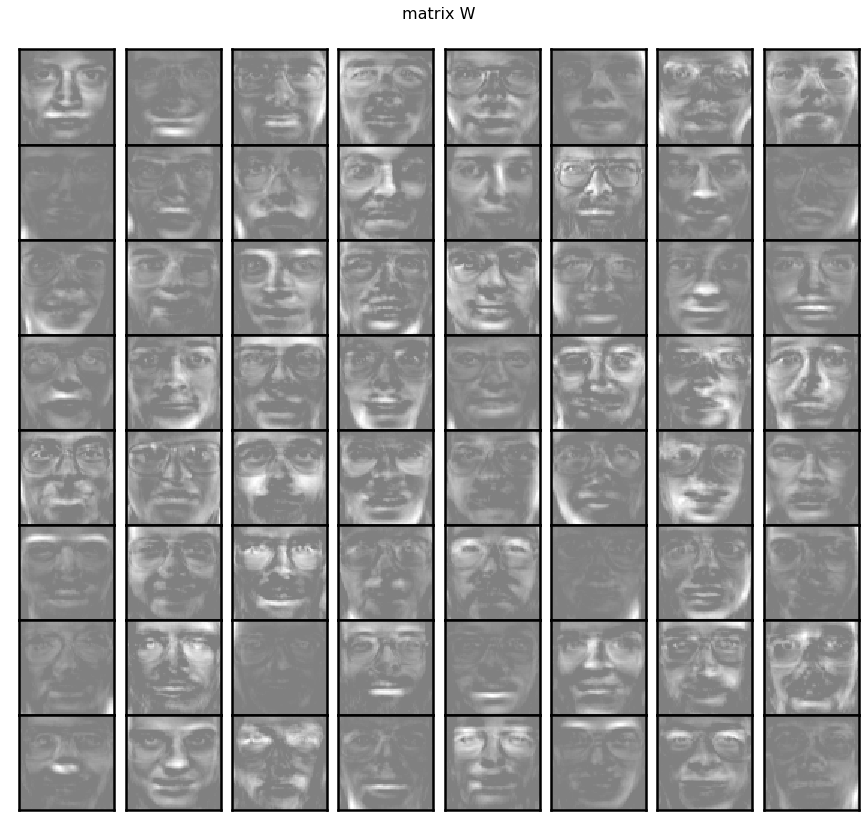

In [7]:
W = model.W_.T
plot_faces('matrix W', W, image_shape, n_col = np.sqrt(n_components), n_row = np.sqrt(n_components))

(400, 64)


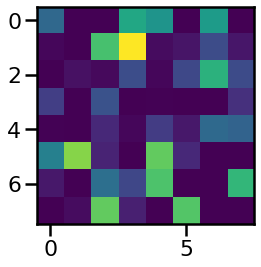

In [8]:
H = model.H_.T
print(H.shape)
H = model.H_.T
plt.imshow(H[0].reshape(8, 8));

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with NMF. Print the most common words of each topic.

In [9]:
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize

In [10]:
dataset = fetch_20newsgroups(subset='test',categories = ['soc.religion.christian',
                                                        'comp.os.ms-windows.misc', 'sci.space'])

In [11]:
len(dataset.data)

1186

## Preprocessing

We choose to preprocess the newsgroup on our way :
we work only with 3 categories and we take in account only the 25000 most common words. We then apply the classical tf-idf transformation on the words

In [12]:
vectorizer = CountVectorizer(analyzer='word', max_features=20000, stop_words = 'english')
x_counts = vectorizer.fit_transform(dataset.data);
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [13]:
print("documents shape", xtfidf_norm.shape)
n_components = len(dataset.target_names)
print("n_components", n_components)

documents shape (1186, 20000)
n_components 3


 iteration 50 error = 0.0008962124667131685
 iteration 100 error = 0.0001346038352267873
 iteration 150 error = 4.6488561227680126e-05
 iteration 200 error = 8.676176121756845e-05


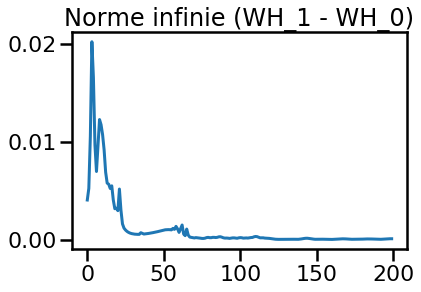

In [14]:
model_F = my_NMF(n_components, loss = 'Frobenius', epsilon = 1e-5, max_iter = 200)
model_F.fit_transform(xtfidf_norm.A);

 iteration 50 error = 0.00021195390470244487
 iteration 100 error = 0.0004452651075674465
 iteration 150 error = 0.00029770489824036683
 iteration 200 error = 0.0003131566079442776
 iteration 250 error = 0.0002971001291485701
 iteration 300 error = 0.0004835947810950458
 iteration 350 error = 0.0004221408388687944
 iteration 400 error = 0.0004691670741478974
 iteration 450 error = 0.000435234506054281
 iteration 500 error = 0.000530261129952869


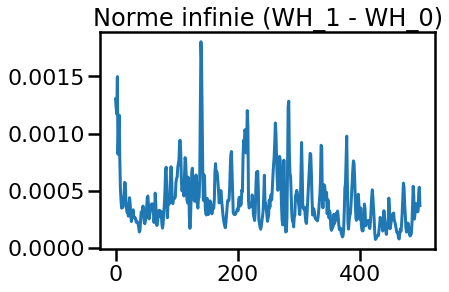

In [15]:
model_KL = my_NMF(n_components, loss = 'KL', epsilon = 1e-5, max_iter = 500)
model_KL.fit_transform(xtfidf_norm.A)

In [17]:
import pandas as pd
def get_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(n_components):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.W_.T[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [18]:
print(dataset.target_names)

['comp.os.ms-windows.misc', 'sci.space', 'soc.religion.christian']


In [19]:
df_F = get_topics(model_F, 20)
df_KL = get_topics(model_KL, 20)

In [20]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

print('          Frobenius                           KL')
display_side_by_side(df_F, df_KL)

          Frobenius                           KL


,Topic # 01,Topic # 02,Topic # 03
0,edu,access,petch
1,windows,digex,gvg47
2,com,pat,gvg
3,university,net,chuck
4,subject,prb,tek
5,organization,henry,daily
6,lines,express,verse
7,microsoft,online,com
8,dos,toronto,proverbs
9,os,communications,harm


### Analysis of the result

We first notice that KL divergence perform way better than the Frobenius norm in modeling the topics in terms of speed of convergence and classifying words according to topics.


The perfomance with KL seems to be quite good as it can be seen in the previous dataframe:
- the topic 1 corresponds to comp.os.ms-windows.misc
- the topic 2 corresponds to sci.space
- the topic 3 corresponds to soc.religion.christian

We can now compute the accuracy of NMF model.

In [21]:
target = pd.DataFrame()
target['real_topic'] = dataset.target
target['computed_topic'] = np.argmax(model_KL.H_.T, axis=1)

In [22]:
print("Accuracy of the model :", (target['real_topic'] == target.computed_topic).mean())

Accuracy of the model : 0.7765598650927488
